# ASL Project

In [1]:
#Import libraries
import numpy as np
import random

# Imports to view data
import cv2
import pandas as pd
from glob import glob

# Visualization
from keras.utils import print_summary
from matplotlib import pyplot as plt

#ML libraries
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
#Directory paths
TRAIN_DIR = "../Dataset/asl_alphabet_train/asl_alphabet_train"
TEST_DIR = "../Dataset/asl_alphabet_test"
MODEL_DIR = './Model'
MODEL_PATH = MODEL_DIR+"/Model1-resnet.h5"
MODEL_WEIGHT_PATH = MODEL_DIR+"/Model_Weight1-resnet.h5"

In [3]:
# Set global variables
TARGET_SIZE = (64, 64)
TARGET_DIMS = (64, 64, 3) # add channel for RGB
CLASSES = 29
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 64

## Data Augmentation

In [4]:
#Load Train dataset
train_image_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=VALIDATION_SPLIT
)

validation_image_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    validation_split=VALIDATION_SPLIT
)

train_generator = train_image_generator.flow_from_directory(TRAIN_DIR, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, shuffle=True, subset="training")
val_generator = validation_image_generator.flow_from_directory(TRAIN_DIR, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


## Model

In [5]:
#Define Model Xception Model
def ResNet_model_build():
    from keras.applications.resnet50 import ResNet50
    from keras.layers import Input

    input_tensor = Input(shape=TARGET_DIMS)
    model = ResNet50(input_tensor = input_tensor, weights=None, include_top=True, classes= CLASSES)
    return model

In [6]:
from keras.models import Model
base_model = ResNet_model_build()
x = base_model.output
#x = (Dense(CLASSES, activation='softmax'))(x)
model = Model(inputs=base_model.input, outputs=x)

#Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.summary()
model.save(MODEL_PATH)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

KeyboardInterrupt: 

In [8]:
#Checkpointer to save the best models
checkpointer = ModelCheckpoint(filepath=MODEL_WEIGHT_PATH, 
                               verbose=1, save_best_only=True)

steps_per_epoch = int( np.ceil(len(train_generator)*2 / BATCH_SIZE) )
validation_steps = int( np.ceil(len(val_generator)*2 / BATCH_SIZE) )

history = model.fit_generator(train_generator, validation_data=val_generator, 
                    steps_per_epoch =  steps_per_epoch,
                    validation_steps = validation_steps,
                    epochs=20, callbacks=[checkpointer], verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
39/39 [==============================] - 336s 9s/step - loss: 4.6791 - acc: 0.0333 - val_loss: 9.9420 - val_acc: 0.0250

Epoch 00001: val_loss improved from inf to 9.94200, saving model to ./Model/Model_Weight1-resnet.h5
Epoch 2/20
39/39 [==============================] - 324s 8s/step - loss: 4.2687 - acc: 0.0469 - val_loss: 4.8099 - val_acc: 0.0406

Epoch 00002: val_loss improved from 9.94200 to 4.80988, saving model to ./Model/Model_Weight1-resnet.h5
Epoch 3/20
39/39 [==============================] - 337s 9s/step - loss: 4.0721 - acc: 0.0533 - val_loss: 12.4869 - val_acc: 0.0219

Epoch 00003: val_loss did not improve from 4.80988
Epoch 4/20
39/39 [==============================] - 330s 8s/step - loss: 3.7194 - acc: 0.0585 - val_loss: 4.4409 - val_acc: 0.0625

Epoch 00004: val_loss improved from 4.80988 to 4.44090, saving model to ./Model/Model_Weight1-resnet.h5
Epoch 5/20
39/39 [==============================] - 331s 8s/step

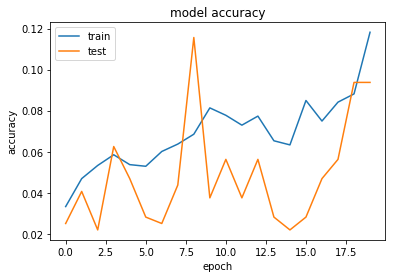

In [9]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

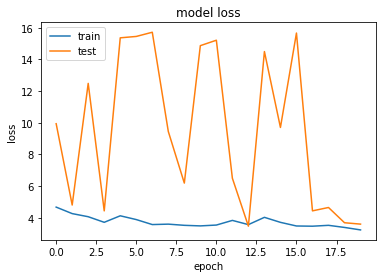

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
#Predict on validation dataset
predictions = model.predict_generator(val_generator, steps=1)        
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

predictions = [label_map[k] for k in predictions]

print(predictions, len(predictions))

loss, acc = model.evaluate_generator(val_generator, steps=1, verbose=0)

print(loss,",",acc)

['F', 'Q', 'Z', 'Z', 'Z', 'Q', 'E', 'R', 'Q', 'Z', 'Z', 'F', 'Z', 'C', 'Q', 'C', 'Q', 'C', 'nothing', 'O', 'C', 'Z', 'Z', 'Q', 'Z', 'Z', 'Z', 'Z', 'C', 'Z', 'C', 'Z', 'C', 'F', 'Z', 'Z', 'F', 'nothing', 'F', 'Z', 'Z', 'F', 'F', 'E', 'F', 'F', 'Z', 'C', 'C', 'F', 'Q', 'Q', 'F', 'Q', 'Z', 'Q', 'D', 'Z', 'Q', 'Q', 'F', 'C', 'Z', 'Z'] 64
3.446183681488037 , 0.03125


In [12]:
test_image_generator = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,
)

test_generator = test_image_generator.flow_from_directory(TEST_DIR, target_size=TARGET_SIZE, batch_size=28, shuffle=False, 
    class_mode='categorical')
print(test_generator.classes)

Found 28 images belonging to 1 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:
#Predict
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=1)
predictions = np.argmax(predictions, axis=1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

predictions = [label_map[k] for k in predictions]

print(predictions, len(predictions))

['D', 'D', 'F', 'F', 'D', 'F', 'F', 'F', 'F', 'F', 'D', 'F', 'F', 'F', 'F', 'F', 'F', 'K', 'F', 'C', 'K', 'K', 'F', 'C', 'F', 'Q', 'Z', 'F'] 28


In [14]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
#print(results)

In [15]:
count = 0
for file,prediction in zip(filenames,predictions):
    #print(file,prediction)
    if(prediction+'_test' in file):
        count+=1
        
print("accuracy",count/len(filenames)*100)

accuracy 3.571428571428571


In [16]:
#Define ResNet Model with pretrained weight
def Xception_model_build_weight():
    from keras.applications.resnet50 import ResNet50
    from keras.layers import Input

    input_tensor = Input(shape=TARGET_DIMS)
    model = ResNet50(input_tensor = input_tensor, weights='imagenet', include_top=False)
    return model

from keras.models import Model
weight_base_model = Xception_model_build_weight()
x1 = weight_base_model.output
#Add the fully-connected layers 
x1 = Flatten(name='flatten')(x1)
x1 = Dense(4096, activation='relu', name='fc1')(x1)
x1 = Dense(4096, activation='relu', name='fc2')(x1)
x1 = Dense(CLASSES, activation='softmax', name='predictions')(x1)
weight_model = Model(inputs=weight_base_model.input, outputs=x1)

#Compile the model
weight_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

weight_model.summary()
MODEL_PATH = MODEL_DIR+"/Model1-resnet-withweight.h5"
weight_model.save(MODEL_PATH)

C:\Users\SHIV\Anaconda3\envs\deeplearning\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 71s 1us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________

In [18]:
#Checkpointer to save the best models
MODEL_WEIGHT_PATH = MODEL_DIR+"/Model_Weight1-resnet-withweight.h5"
checkpointer = ModelCheckpoint(filepath=MODEL_WEIGHT_PATH, 
                               verbose=1, save_best_only=True)

steps_per_epoch = int( np.ceil(len(train_generator)*2 / BATCH_SIZE) )
validation_steps = int( np.ceil(len(val_generator)*2 / BATCH_SIZE) )

weight_history = weight_model.fit_generator(train_generator, validation_data=val_generator, 
                    steps_per_epoch =  steps_per_epoch,
                    validation_steps = validation_steps,
                    epochs=10, callbacks=[checkpointer], verbose=1)

Epoch 1/10
39/39 [==============================] - 367s 9s/step - loss: 4.7848 - acc: 0.0641 - val_loss: 4.0128 - val_acc: 0.1219

Epoch 00001: val_loss improved from inf to 4.01276, saving model to ./Model/Model_Weight1-resnet-withweight.h5
Epoch 2/10
39/39 [==============================] - 353s 9s/step - loss: 3.6410 - acc: 0.1430 - val_loss: 6.4815 - val_acc: 0.1406

Epoch 00002: val_loss did not improve from 4.01276
Epoch 3/10
39/39 [==============================] - 353s 9s/step - loss: 3.3360 - acc: 0.1575 - val_loss: 2.7866 - val_acc: 0.1835

Epoch 00003: val_loss improved from 4.01276 to 2.78656, saving model to ./Model/Model_Weight1-resnet-withweight.h5
Epoch 4/10
39/39 [==============================] - 348s 9s/step - loss: 2.9689 - acc: 0.1723 - val_loss: 3.0642 - val_acc: 0.1875

Epoch 00004: val_loss did not improve from 2.78656
Epoch 5/10
39/39 [==============================] - 358s 9s/step - loss: 2.7334 - acc: 0.1983 - val_loss: 3.7052 - val_acc: 0.0969

Epoch 00005:

In [19]:
#Predict on validation dataset
predictions = weight_model.predict_generator(val_generator, steps=1)        
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

predictions = [label_map[k] for k in predictions]

print(predictions, len(predictions))

loss, acc = weight_model.evaluate_generator(val_generator, steps=1, verbose=0)

print(loss,",",acc)

['F', 'C', 'C', 'F', 'F', 'C', 'F', 'F', 'F', 'C', 'C', 'O', 'O', 'C', 'C', 'F', 'F', 'F', 'C', 'F', 'C', 'F', 'O', 'C', 'C', 'O', 'F', 'D', 'F', 'C', 'C', 'F', 'F', 'D', 'C', 'C', 'F', 'C', 'C', 'C', 'C', 'C', 'F', 'C', 'O', 'C', 'O', 'C', 'C', 'F', 'F', 'F', 'O', 'C', 'C', 'F', 'C', 'F', 'F', 'C', 'C', 'C', 'C', 'O'] 64
9.353357315063477 , 0.0625


In [20]:
test_image_generator = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,
)

test_generator = test_image_generator.flow_from_directory(TEST_DIR, target_size=TARGET_SIZE, batch_size=28, shuffle=False, 
    class_mode='categorical')
print(test_generator.classes)

Found 28 images belonging to 1 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [21]:
#Predict
test_generator.reset()
predictions = weight_model.predict_generator(test_generator, steps=1)
predictions = np.argmax(predictions, axis=1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v

predictions = [label_map[k] for k in predictions]

print(predictions, len(predictions))

['F', 'C', 'C', 'C', 'F', 'C', 'C', 'C', 'F', 'F', 'F', 'F', 'C', 'F', 'C', 'F', 'C', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'C', 'F', 'C', 'C'] 28


In [23]:
filenames=test_generator.filenames
count = 0
for file,prediction in zip(filenames,predictions):
    print(file,prediction)
    if(prediction+'_test' in file):
        count+=1
        
print("accuracy",count/len(filenames)*100)

asl_alphabet_test\A_test.jpg F
asl_alphabet_test\B_test.jpg C
asl_alphabet_test\C_test.jpg C
asl_alphabet_test\D_test.jpg C
asl_alphabet_test\E_test.jpg F
asl_alphabet_test\F_test.jpg C
asl_alphabet_test\G_test.jpg C
asl_alphabet_test\H_test.jpg C
asl_alphabet_test\I_test.jpg F
asl_alphabet_test\J_test.jpg F
asl_alphabet_test\K_test.jpg F
asl_alphabet_test\L_test.jpg F
asl_alphabet_test\M_test.jpg C
asl_alphabet_test\N_test.jpg F
asl_alphabet_test\O_test.jpg C
asl_alphabet_test\P_test.jpg F
asl_alphabet_test\Q_test.jpg C
asl_alphabet_test\R_test.jpg F
asl_alphabet_test\S_test.jpg F
asl_alphabet_test\T_test.jpg F
asl_alphabet_test\U_test.jpg F
asl_alphabet_test\V_test.jpg F
asl_alphabet_test\W_test.jpg F
asl_alphabet_test\X_test.jpg F
asl_alphabet_test\Y_test.jpg C
asl_alphabet_test\Z_test.jpg F
asl_alphabet_test\nothing_test.jpg C
asl_alphabet_test\space_test.jpg C
accuracy 3.571428571428571
